In [128]:
from pyspark import SparkContext, SparkConf

from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.feature import VectorIndexer, QuantileDiscretizer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator 
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml import Pipeline

from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import mean, col, split, col, when, lit
from pyspark.sql import*

In [163]:
conf = SparkConf().setMaster("local[*]").setAppName("sparkproject")
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)
sc

<SparkContext master=local appName=sparkproject>

In [130]:
#dataframe 
#set header property true for the actual header columns
df=sqlContext.read.csv("bank-full.csv", inferSchema=True, header=True, sep=";")
#display the columns from the dataframe
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [131]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [132]:
df.show(5, truncate=False)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job         |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|y  |
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|58 |management  |married|tertiary |no     |2143   |yes    |no  |unknown|5  |may  |261     |1       |-1   |0       |unknown |no |
|44 |technician  |single |secondary|no     |29     |yes    |no  |unknown|5  |may  |151     |1       |-1   |0       |unknown |no |
|33 |entrepreneur|married|secondary|no     |2      |yes    |yes |unknown|5  |may  |76      |1       |-1   |0       |unknown |no |
|47 |blue-collar |married|unknown  |no     |1506   |yes    |no  |unknown|5  |may  |92      |1       |-1   |0       |unknown |no |
|33 |unknown     |single |unknown  |no     |1      |no     |no  |unknown|5  |may  |198    

In [133]:
customer_count = df.count()
print("The number of customers is {}".format(customer_count))

The number of customers is 45211


In [134]:
group_customer = df.groupBy("age").count()
group_customer.show()

+---+-----+
|age|count|
+---+-----+
| 31| 1996|
| 85|    5|
| 65|   59|
| 53|  891|
| 78|   30|
| 34| 1930|
| 81|   17|
| 28| 1038|
| 76|   32|
| 27|  909|
| 26|  805|
| 44| 1136|
| 22|  129|
| 93|    2|
| 47| 1088|
| 52|  911|
| 86|    9|
| 40| 1355|
| 20|   50|
| 94|    1|
+---+-----+
only showing top 20 rows



In [135]:
display(group_customer)

DataFrame[age: int, count: bigint]

In [136]:
def get_dummy(df, categoricalCols, continuousCols, labelCol):
  
  indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categoricalCols]

  encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                             outputCol="{0}_encoded".format(indexer.getOutputCol()))
              for indexer in indexers]

  assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                              + continuousCols, outputCol="features")
  
  indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')


  pipeline = Pipeline(stages = indexers + encoders + [assembler] + [indexer])

  model=pipeline.fit(df)
  data = model.transform(df)

  data = data.withColumn('label', col(labelCol))
  
  return data.select('features', 'indexedLabel', 'label'), StringIndexer(inputCol='label').fit(data)


In [137]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
(df, labelindexer) = get_dummy(df, categoricalColumns, numericCols, 'y')

+--------------------+------------+-----+
|            features|indexedLabel|label|
+--------------------+------------+-----+
|(30,[1,11,14,16,1...|         0.0|   no|
|(30,[2,12,13,16,1...|         0.0|   no|
|(30,[7,11,13,16,1...|         0.0|   no|
|(30,[0,11,16,17,1...|         0.0|   no|
|(30,[12,16,18,20,...|         0.0|   no|
|(30,[1,11,14,16,1...|         0.0|   no|
|(30,[1,12,14,16,1...|         0.0|   no|
|(30,[7,14,17,18,2...|         0.0|   no|
|(30,[5,11,15,16,1...|         0.0|   no|
|(30,[2,12,13,16,1...|         0.0|   no|
+--------------------+------------+-----+
only showing top 10 rows



In [109]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)

+--------------------+------------+-----+--------------------+
|            features|indexedLabel|label|     indexedFeatures|
+--------------------+------------+-----+--------------------+
|(30,[1,11,14,16,1...|         0.0|   no|(30,[1,11,14,16,1...|
|(30,[2,12,13,16,1...|         0.0|   no|(30,[2,12,13,16,1...|
|(30,[7,11,13,16,1...|         0.0|   no|(30,[7,11,13,16,1...|
|(30,[0,11,16,17,1...|         0.0|   no|(30,[0,11,16,17,1...|
|(30,[12,16,18,20,...|         0.0|   no|(30,[12,16,18,20,...|
+--------------------+------------+-----+--------------------+
only showing top 5 rows



In [138]:
df.show(5, False)

+---------------------------------------------------------------------------------------------------------+------------+-----+
|features                                                                                                 |indexedLabel|label|
+---------------------------------------------------------------------------------------------------------+------------+-----+
|(30,[1,11,14,16,17,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,58.0,2143.0,261.0,1.0,-1.0])|0.0         |no   |
|(30,[2,12,13,16,17,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,44.0,29.0,151.0,1.0,-1.0])  |0.0         |no   |
|(30,[7,11,13,16,17,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,33.0,2.0,76.0,1.0,-1.0])           |0.0         |no   |
|(30,[0,11,16,17,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,47.0,1506.0,92.0,1.0,-1.0])        |0.0         |no   |
|(30,[12,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,33.0,1.0,198.0,1.0,-1.0])                       |0.0 

In [141]:
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=10)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 36185
Test Dataset Count: 9026


In [142]:
print("The first 5 samples of the Training Dataset:")
trainingData.show(5, False)
print("The first 5 samples of the Test Dataset:")
testData.show(5, False)

The first 5 samples of the Training Dataset:
+---------------------------------------------------------------------------------------------------------+------------+-----+
|features                                                                                                 |indexedLabel|label|
+---------------------------------------------------------------------------------------------------------+------------+-----+
|(30,[0,11,13,16,17,18,19,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,-220.0,90.0,1.0,-1.0]) |0.0         |no   |
|(30,[0,11,13,16,17,18,19,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,1470.0,212.0,1.0,-1.0])|0.0         |no   |
|(30,[0,11,13,16,17,18,19,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0,2.0,102.0,2.0,-1.0])   |0.0         |no   |
|(30,[0,11,13,16,17,18,19,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0,59.0,246.0,1.0,-1.0])  |0.0         |no   |
|(30,[0,11,13,16,17,18,19,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,

In [143]:
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="features")

In [144]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelindexer.labels) 
pipeline = Pipeline(stages=[featureIndexer, lr, labelConverter])
lrModel = pipeline.fit(trainingData)

In [145]:
predictions = lrModel.transform(testData)
predictions.show(5)

+--------------------+------------+-----+--------------------+--------------------+--------------------+----------+--------------+
|            features|indexedLabel|label|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+------------+-----+--------------------+--------------------+--------------------+----------+--------------+
|(30,[0,11,13,16,1...|         0.0|   no|(30,[0,11,13,16,1...|[2.48901566578737...|[0.92336818078568...|       0.0|            no|
|(30,[0,11,13,16,1...|         0.0|   no|(30,[0,11,13,16,1...|[0.22022733948194...|[0.55483538708590...|       0.0|            no|
|(30,[0,11,13,16,1...|         0.0|   no|(30,[0,11,13,16,1...|[3.51750649213386...|[0.97118179842432...|       0.0|            no|
|(30,[0,11,13,16,1...|         0.0|   no|(30,[0,11,13,16,1...|[2.19666402063509...|[0.89994953858362...|       0.0|            no|
|(30,[0,11,13,16,1...|         1.0|  yes|(30,[0,11,13,16,1...|[-0.4111570922003...|

In [146]:
predictions.select("features", "label", "probability", "predictedLabel").show(5)

+--------------------+-----+--------------------+--------------+
|            features|label|         probability|predictedLabel|
+--------------------+-----+--------------------+--------------+
|(30,[0,11,13,16,1...|   no|[0.92336818078568...|            no|
|(30,[0,11,13,16,1...|   no|[0.55483538708590...|            no|
|(30,[0,11,13,16,1...|   no|[0.97118179842432...|            no|
|(30,[0,11,13,16,1...|   no|[0.89994953858362...|            no|
|(30,[0,11,13,16,1...|  yes|[0.39863470462798...|           yes|
+--------------------+-----+--------------------+--------------+
only showing top 5 rows



In [147]:
cm = predictions.select("label", "predictedLabel")          
cm.groupby('label').agg({'label': 'count'}).show()  
cm.groupby('predictedLabel').agg({'predictedLabel': 'count'}).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|   no|        7942|
|  yes|        1084|
+-----+------------+

+--------------+---------------------+
|predictedLabel|count(predictedLabel)|
+--------------+---------------------+
|            no|                 8498|
|           yes|                  528|
+--------------+---------------------+



In [148]:
predictions.groupBy('label', 'predictedLabel').count().show()

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|   no|            no| 7757|
|   no|           yes|  185|
|  yes|           yes|  343|
|  yes|            no|  741|
+-----+--------------+-----+



In [152]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", 
                                              predictionCol="prediction", metricName="accuracy")
print("Accuracy of the Logistic Regression Model for the test data: {}".format(evaluator.evaluate(predictions)))

Accuracy of the Logistic Regression Model for the test data: 0.8974074894748504


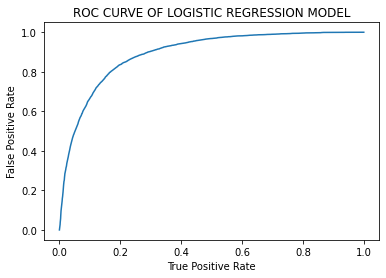

In [154]:
import matplotlib.pyplot as plt
lrModel1 = lrModel.stages[1]
trainingSummary = lrModel1.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC CURVE OF LOGISTIC REGRESSION MODEL')
plt.show()

In [155]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")
rfModel = rf.fit(trainingData)
rf_predictions = rfModel.transform(testData)

In [156]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
print("The Accuracy for test set is {}".format(evaluator.evaluate(rf_predictions)))

The Accuracy for test set is 0.8830046532240196


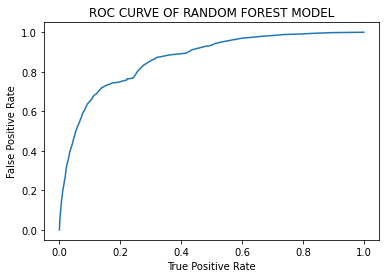

Training data ROC Area Under The Curve: 0.8662306703282893


In [157]:
#rfModel1 = lrModel.stages[1]
trainingSummary = rfModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC CURVE OF RANDOM FOREST MODEL')
plt.show()
print('Training data ROC Area Under The Curve: ' + str(trainingSummary.areaUnderROC))

In [158]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features")
pipeline = Pipeline(stages=[featureIndexer, gbt, labelConverter])
gbtModel = pipeline.fit(trainingData)
gbt_predictions = gbtModel.transform(testData)

In [159]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
print("The Accuracy for test set is {}".format(evaluator.evaluate(gbt_predictions)))

The Accuracy for test set is 0.8954132506093507


In [160]:
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel")
print('Area Under ROC for Gradient Boosting model:', evaluator.evaluate(gbt_predictions))

Area Under ROC for Gradient Boosting model: 0.8917245161182407


In [94]:
sc.stop()